In [1]:
import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt 
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
np.random.seed(7)

df = pd.read_csv(r"D:\python建模\工程训练营\aiSummerCamp2022\大作业2\02 His_Power_FD.CSV")
df.head() 


,Datetime,Power(MW)
0,2022/7/15 0:00:00,0.0216
1,2022/7/15 0:15:00,0.0218
2,2022/7/15 0:30:00,0.4021
3,2022/7/15 0:45:00,0.5867
4,2022/7/15 1:00:00,0.3889


In [2]:
df  = df.rename(columns={'日期1':'date'})
df

,Datetime,Power(MW)
0,2022/7/15 0:00:00,0.0216
1,2022/7/15 0:15:00,0.0218
2,2022/7/15 0:30:00,0.4021
3,2022/7/15 0:45:00,0.5867
4,2022/7/15 1:00:00,0.3889
...,...,...
667,2022/7/21 22:45:00,2.3584
668,2022/7/21 23:00:00,2.8011
669,2022/7/21 23:15:00,3.6597
670,2022/7/21 23:30:00,3.4466


In [6]:
from datetime import datetime, date 

df['Datetime'] = pd.to_datetime(df['Datetime'])
df.head().style.set_properties(subset=['Datetime'], **{'background-color': 'dodgerblue'})


,Datetime,Power(MW)
0,2022-07-15 00:00:00,0.021600
1,2022-07-15 00:15:00,0.021800
2,2022-07-15 00:30:00,0.402100
3,2022-07-15 00:45:00,0.586700
4,2022-07-15 01:00:00,0.388900


In [11]:
df = df.sort_values(by='Datetime')

# Check time intervals
df['delta'] = df['Datetime'] - df['Datetime'].shift(1)

df[['Datetime', 'delta']].head()


,Datetime,delta
0,2022-07-15 00:00:00,NaT
1,2022-07-15 00:15:00,0 days 00:15:00
2,2022-07-15 00:30:00,0 days 00:15:00
3,2022-07-15 00:45:00,0 days 00:15:00
4,2022-07-15 01:00:00,0 days 00:15:00


In [12]:
df['delta'].sum(), df['delta'].count()


(Timedelta('6 days 23:45:00'), 671)

In [13]:
df = df.drop('delta', axis=1)
df.isna().sum()


Datetime     0
Power(MW)    0
dtype: int64

(17532.0, 17546.0)

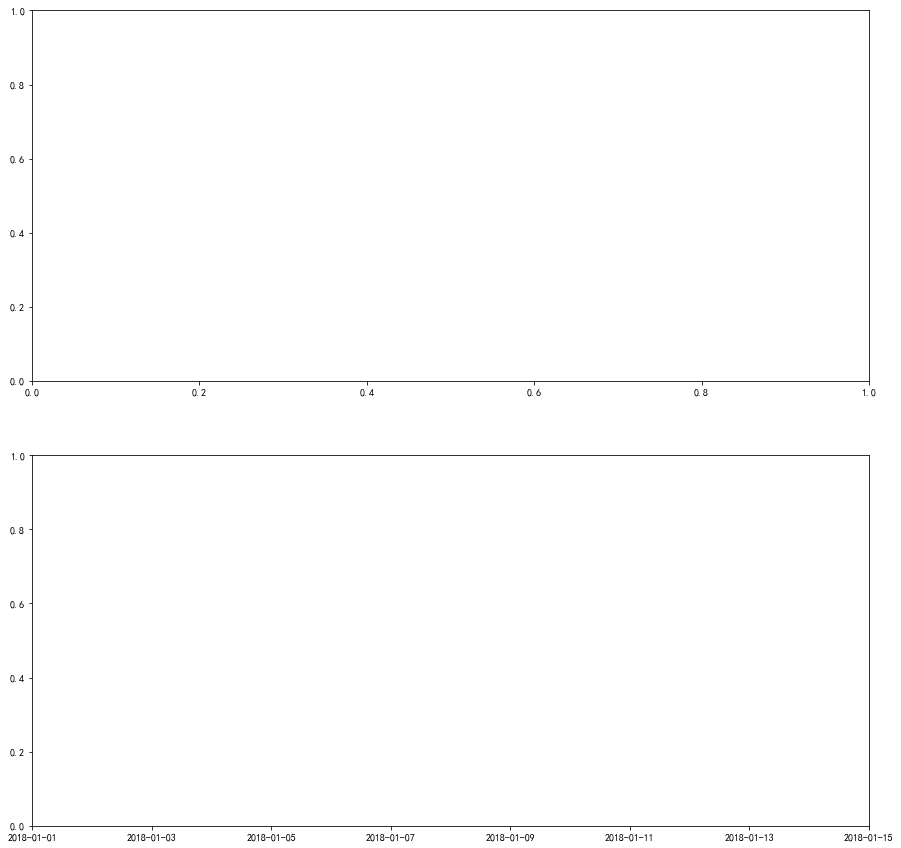

In [14]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))




ax[1].set_xlim([date(2018, 1, 1), date(2018, 1, 15)])


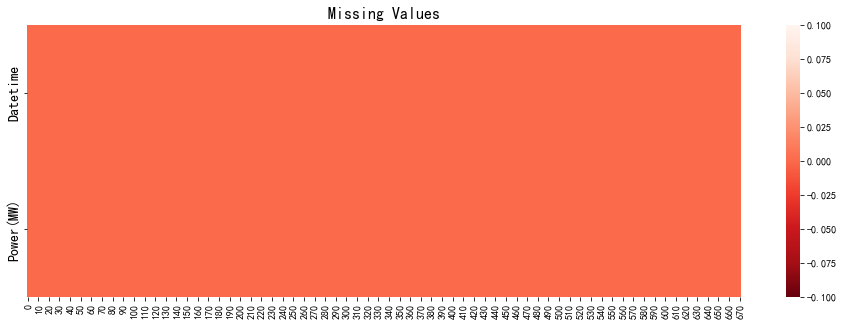

In [15]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Reds_r')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()


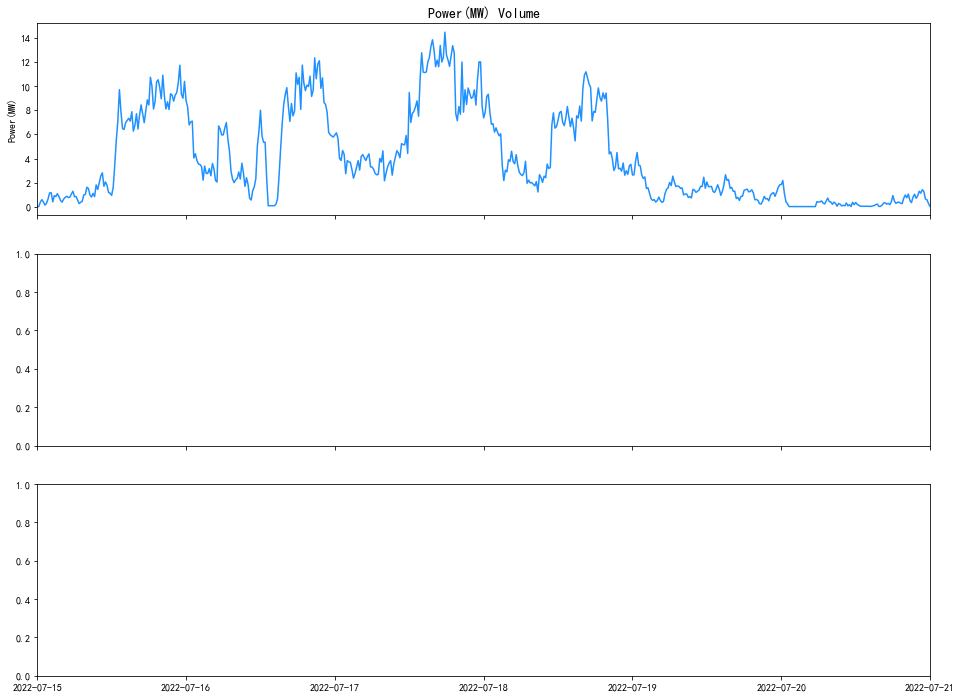

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(16,12))

sns.lineplot(df['Datetime'], df['Power(MW)'], color='dodgerblue', ax=ax[0])
ax[0].set_title('Power(MW) Volume', fontsize=14)

for i in range(3):
    ax[i].set_xlim([date(2022, 7, 15), date(2022, 7, 21)])



In [17]:
# As we can see, downsample to weekly could smooth the data and hgelp with analysis
downsample = df[['Datetime',
                 'Power(MW)', 
                ]].resample('7D', on='Datetime').mean().reset_index(drop=False)

# df = downsample.copy()
downsample


,Datetime,Power(MW)
0,2022-07-15,3.710794


In [18]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['Datetime']
y = df['Power(MW)']

folds = TimeSeriesSplit(n_splits=N_SPLITS)


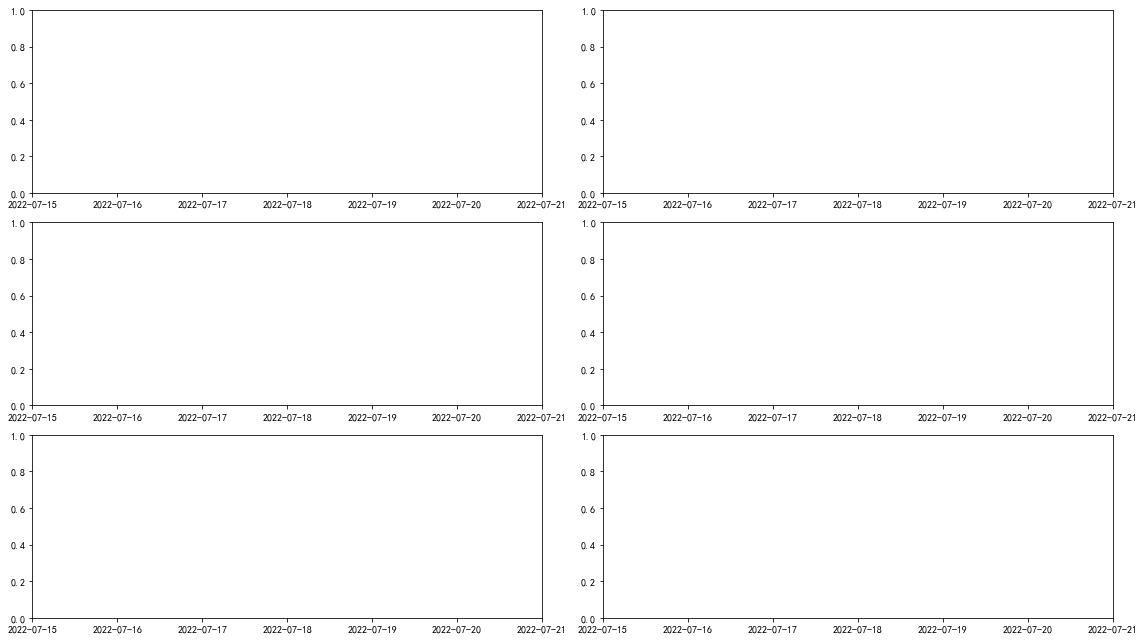

In [21]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

#for i, (train_index, valid_index) in enumerate(folds.split(X)):
    
for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2022, 7, 15), date(2022, 7, 21)])
    ax[i, 1].set_xlim([date(2022, 7, 15), date(2022, 7, 21)])
    
plt.tight_layout()
plt.show()


In [22]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size
df = df.fillna(0)
univariate_df = df[['Datetime', 'Power(MW)']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))


571 101


In [24]:
df.columns

Index(['Datetime', 'Power(MW)'], dtype='object')

In [27]:
# feature_columns = [
#      '最高温度', '最低温度', '白天风力风向', '夜晚风力风向', '天气1', '天气2'
# ]
target_column = ['Power(MW)']

train_size = int(0.85 * len(df))

multivariate_df = df[['Datetime'] + target_column ].copy()
multivariate_df.columns = ['ds', 'y'] 

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()


,ds,y
0,2022-07-15 00:00:00,0.0216
1,2022-07-15 00:15:00,0.0218
2,2022-07-15 00:30:00,0.4021
3,2022-07-15 00:45:00,0.5867
4,2022-07-15 01:00:00,0.3889


In [43]:
train  =multivariate_df.iloc[:train_size, :]
train


,ds,y
0,2022-07-15 00:00:00,0.0216
1,2022-07-15 00:15:00,0.0218
2,2022-07-15 00:30:00,0.4021
3,2022-07-15 00:45:00,0.5867
4,2022-07-15 01:00:00,0.3889
...,...,...
566,2022-07-20 21:30:00,1.0410
567,2022-07-20 21:45:00,0.7024
568,2022-07-20 22:00:00,0.9116
569,2022-07-20 22:15:00,1.2818


In [44]:
from fbprophet import Prophet


# Train the model
model = Prophet()
# model.add_regressor('最高温度')
# model.add_regressor('最低温度')
# model.add_regressor('白天风力风向')
# model.add_regressor('夜晚风力风向')
# model.add_regressor('天气1')
# model.add_regressor('天气2')
# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))


ModuleNotFoundError: No module named 'fbprophet'

In [39]:
from sklearn.metrics import r2_score
print('R2-score:',r2_score(y_valid, y_pred['yhat']))


NameError: name 'y_pred' is not defined

NameError: name 'model' is not defined

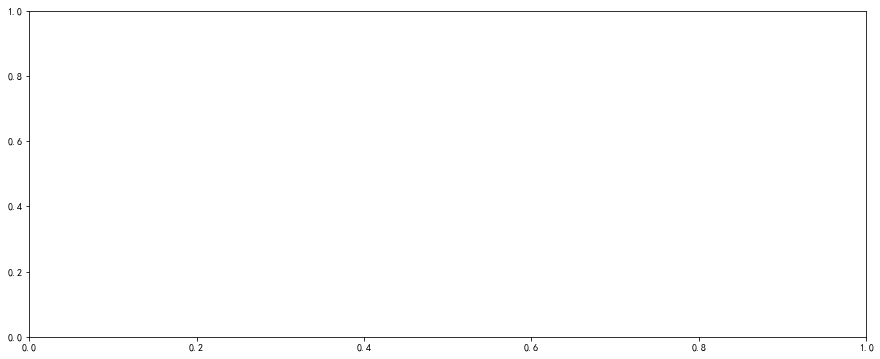

In [38]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Datetime', fontsize=14)
ax.set_ylabel(ylabel='Power(MW)', fontsize=14)

plt.show()
